/tmp/ipython-input-4117576329.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[numeric_cols] = df[numeric_cols].fillna(method='ffill').fillna(method='bfill')


Training samples: 1082 | Features per window: 8 | Outputs: 5
Epoch 1/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.1039 - mae: 0.2567 - val_loss: 0.0429 - val_mae: 0.1573
Epoch 2/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0383 - mae: 0.1486 - val_loss: 0.0374 - val_mae: 0.1455
Epoch 3/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0327 - mae: 0.1355 - val_loss: 0.0364 - val_mae: 0.1480
Epoch 4/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0317 - mae: 0.1336 - val_loss: 0.0347 - val_mae: 0.1421
Epoch 5/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0287 - mae: 0.1272 - val_loss: 0.0333 - val_mae: 0.1379
Epoch 6/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0321 - mae: 0.1344 - val_loss: 0.0352 - val_mae: 0.1387
Epoch 7/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0270 - mae: 0.1245 - val_loss: 0.0338 - val_mae: 0.1412
Epoch 8/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0301 - mae: 0.1310 - val_loss: 0.0341 - val_mae: 0.1360
Epo

,date,precip,humidity,sealevelpressure,windspeed,windgust,rain_chance_%
0,2025-11-12,0.12,56.78,1012.01,14.56,27.60,24.00
1,2025-11-13,0.12,56.42,1011.83,14.76,27.60,24.00
2,2025-11-14,0.12,56.87,1012.00,14.62,27.15,24.00
3,2025-11-15,0.13,57.25,1012.17,14.55,26.89,26.00
4,2025-11-16,0.13,57.52,1012.32,14.51,26.70,26.00
5,2025-11-17,0.13,57.80,1012.49,14.47,26.57,26.00
6,2025-11-18,0.14,58.07,1012.64,14.45,26.47,28.00


,date,avg_temp,max_temp,min_temp
0,2025-11-12,46.57,52.97,40.83
1,2025-11-13,47.76,54.34,41.98
2,2025-11-14,48.96,55.71,43.12
3,2025-11-15,50.16,57.09,44.27
4,2025-11-16,51.36,58.46,45.42
5,2025-11-17,52.55,59.83,46.56
6,2025-11-18,53.75,61.20,47.71


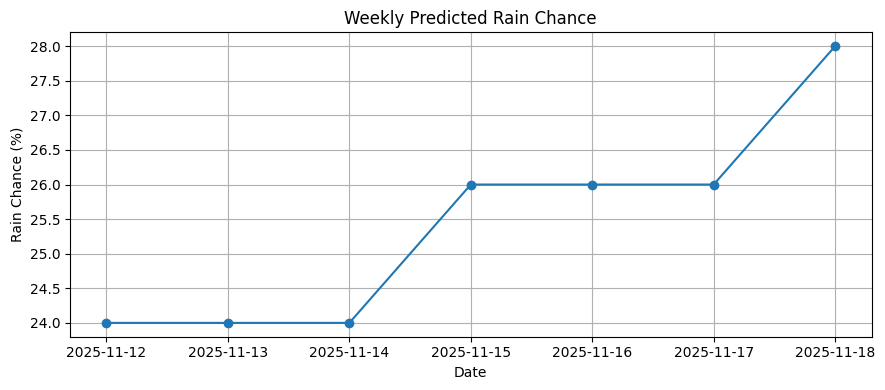

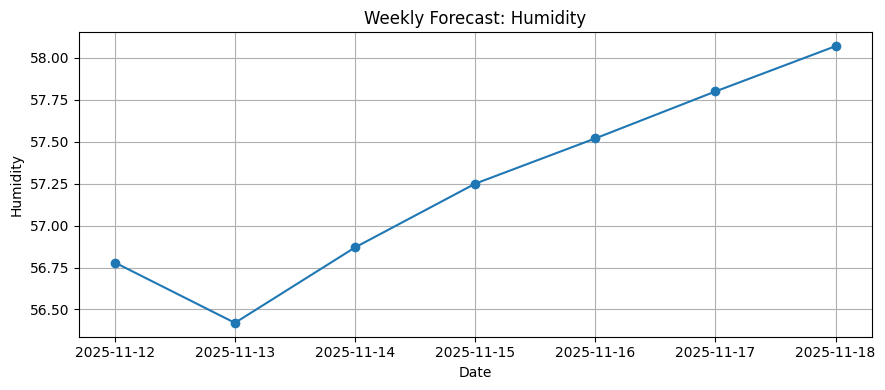

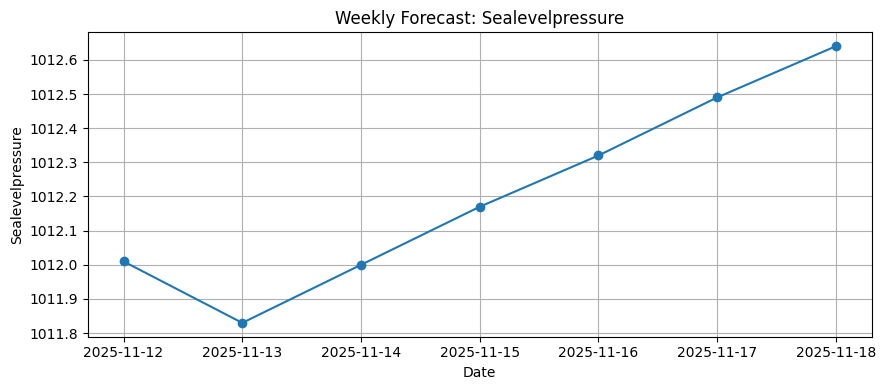

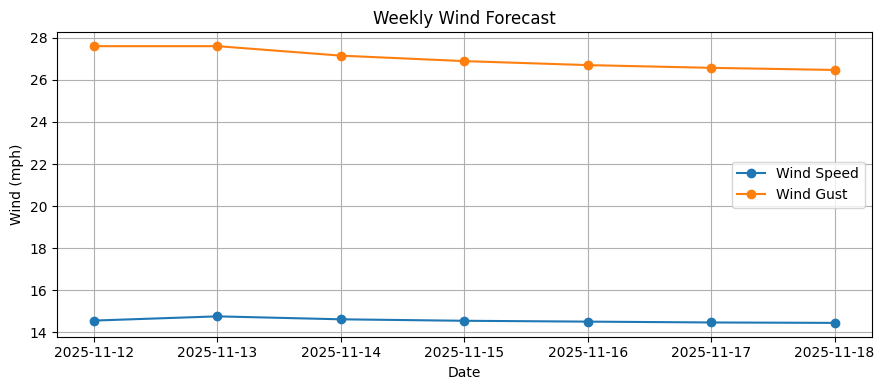

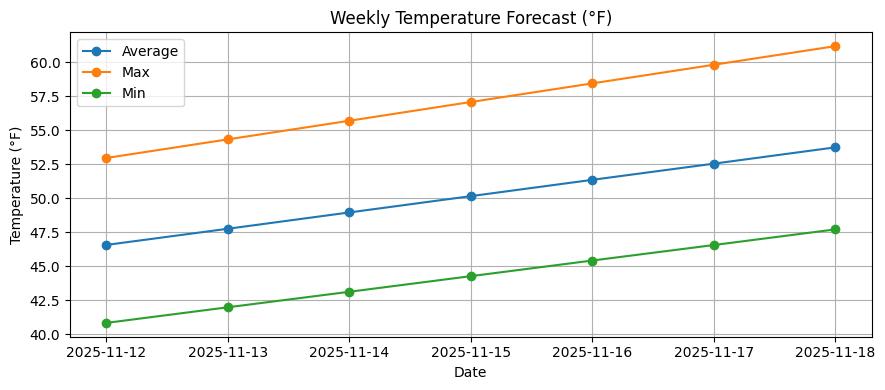

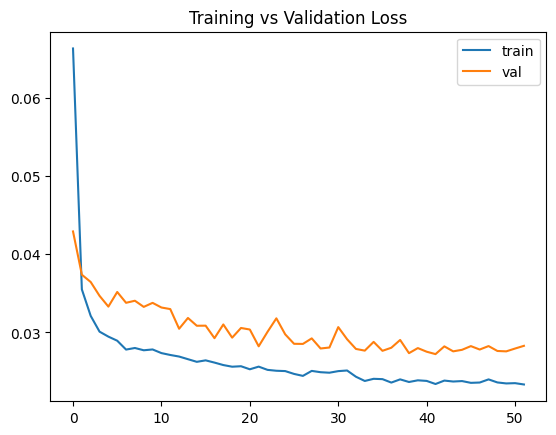

Saved artifact at '/tmp/tmpqekv1fhg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 14, 8), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  138346402216464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138344413051792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138346544782928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138344413051984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138346544782544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138346411115728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138346411116304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138346544791376: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite multi-output model saved as weather_prediction_model.tflite


In [ ]:
# === Weather Forecaster v5 by Amraj Takhar ===

# --- Import libraries and files -----------------------------------------------
csv_path = "/content/NYCDataset.csv"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Test if TensorFlow works. If not, use something else ---------------------

use_tensorflow = False
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras.callbacks import EarlyStopping
    use_tensorflow = True
except Exception:
    use_tensorflow = False

# --- Imports Multi-Layer Perceptron regressor, the something else -------------

from sklearn.neural_network import MLPRegressor

# --- Loads and cleans the data in the csv file, proper formatting, ------------
# --- chronological dates, numerical columns, etc. -----------------------------

df = pd.read_csv(csv_path)
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df = df.sort_values('datetime').reset_index(drop=True)
df = df[~df['datetime'].isna()].copy()

numeric_cols = ['tempmax','tempmin','temp','humidity','precip','precipprob',
                'windgust','windspeed','sealevelpressure']
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
df[numeric_cols] = df[numeric_cols].fillna(method='ffill').fillna(method='bfill')
df['date'] = df['datetime'].dt.date

# --- What features/targets (inputs/outputs) is my model using -----------------
# --- Also prevents high precip values from skewing the model. -----------------

features = [f for f in ['temp','tempmax','tempmin','humidity','precip','windspeed','windgust','sealevelpressure'] if f in df.columns]
targets = [f for f in ['precip','humidity','sealevelpressure','windspeed','windgust'] if f in df.columns]

data = df[['datetime'] + features].copy().reset_index(drop=True)
if 'precip' in data.columns:
    data['precip'] = np.clip(data['precip'], 0, np.percentile(data['precip'], 99))

# --- Preparing the data for time-series modeling. Window size looks back ------
# --- 14 days is best, doesn't decrease val_loss much. -------------------------
# --- Also prints how many training samples/features/outputs there are ---------

window_size = 14
X_list, y_list, dt_list = [], [], []

for i in range(len(data) - window_size):
    window = data.loc[i:i+window_size-1, features].values
    X_list.append(window.flatten())
    y_list.append(data.loc[i+window_size, targets].values)
    dt_list.append(data.loc[i+window_size, 'datetime'])

X = np.array(X_list)
y = np.array(y_list)
print(f"Training samples: {len(X)} | Features per window: {len(features)} | Outputs: {len(targets)}")

# --- Predicts the daily temperature a week ahead, forecasts future days. ------
# --- Uses simple linear trends, falls back if not enough data. ----------------

def forecast_daily_avg_temp(df, days_ahead=7):
    daily = df.groupby('date')[['temp','tempmax','tempmin']].mean().dropna().sort_index()
    if len(daily) >= 7:
        n_fit = min(14, len(daily))
        daily_fit = daily.iloc[-n_fit:]
        avg_coef = np.polyfit(np.arange(len(daily_fit)), daily_fit['temp'], deg=1)
        max_coef = np.polyfit(np.arange(len(daily_fit)), daily_fit['tempmax'], deg=1)
        min_coef = np.polyfit(np.arange(len(daily_fit)), daily_fit['tempmin'], deg=1)
        x_next = np.arange(len(daily_fit), len(daily_fit)+days_ahead)
        return (
            np.round(np.polyval(avg_coef, x_next), 2).tolist(),
            np.round(np.polyval(max_coef, x_next), 2).tolist(),
            np.round(np.polyval(min_coef, x_next), 2).tolist()
        )
    else:
        last_avg = daily['temp'].iloc[-1] if len(daily) > 0 else df['temp'].iloc[-1]
        last_max = daily['tempmax'].iloc[-1] if len(daily) > 0 else df['tempmax'].iloc[-1]
        last_min = daily['tempmin'].iloc[-1] if len(daily) > 0 else df['tempmin'].iloc[-1]
        return [round(float(last_avg),2)]*days_ahead, [round(float(last_max),2)]*days_ahead, [round(float(last_min),2)]*days_ahead

# --- Adds fallback if there's not enough samples in the dataset. --------------
# --- Prepares the data for training. ------------------------------------------

if X.shape[0] < 50:
    print("\nNot enough samples for DNN. Using persistence fallback.")
    last_row = data.iloc[-1]
    today = pd.Timestamp.today().normalize().date()
    future_dates = [today + timedelta(days=i) for i in range(7)]
    persistence_preds = pd.DataFrame({
        'date': future_dates,
        **{t: [last_row[t]]*7 for t in targets}
    }).round(2)
    display(persistence_preds)

else:
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    scaler_X = MinMaxScaler().fit(X_train)
    X_train_s = scaler_X.transform(X_train)
    X_test_s = scaler_X.transform(X_test)

    scaler_y = MinMaxScaler().fit(y_train)
    y_train_s = scaler_y.transform(y_train)
    y_test_s = scaler_y.transform(y_test)

    # --- Checks if tensorflow is enabled, reshape the inputs, clears previous
    # --- sessions. Defines the LSTM model to be used, compile it. Stop the
    # --- model early if val_loss doesn't improve within 10 epochs.
    # --- Then train the model and print how many epochs used before early
    # --- stop triggered.

    if use_tensorflow:
        n_features = len(features)
        X_train_seq_s = X_train_s.reshape(-1, window_size, n_features)
        X_test_seq_s = X_test_s.reshape(-1, window_size, n_features)

        tf.keras.backend.clear_session()
        model = keras.Sequential([
            layers.Input(shape=(window_size, n_features)),
            layers.LSTM(96, activation='tanh', dropout=0.2, recurrent_dropout=0.1),  # dropout randomly ignore 20% of inputs to lessen overfitting
            layers.Dense(48, activation='relu'),                                     # rec dropout randomly ignores 10% of recurrent connections
            layers.Dense(len(targets), activation='linear')
        ])

        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        early = keras.callbacks.EarlyStopping(
            monitor='val_loss',         # stop when validation loss stops improving
            patience=10,                 # wait for 5 epochs of no improvement
            min_delta=1e-4,             # minimum change to qualify as improvement
            restore_best_weights=True,  # revert to best weights
            verbose=1                   # show a message when stopping
        )

        history = model.fit(
            X_train_seq_s, y_train_s,
            validation_split=0.15,
            epochs=60,
            batch_size=32,
            callbacks=[early],
            verbose=1
        )

        print(f"\nTraining stopped after {len(history.history['loss'])} epochs.")


        # --- Make predictions with the trained LSTM, calc MAE + RMSE, then
        # --- print the results. -----------------------------------------------

        y_pred_s = model.predict(X_test_seq_s)
        y_pred = scaler_y.inverse_transform(y_pred_s)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"\nModel Evaluation: MAE = {mae:.3f}, RMSE = {rmse:.3f}")

        # --- Creates multi-day forecasts using trained LSTM (a week) ----------

        last_window = data[features].iloc[-window_size:].values.copy()
        future_preds = []
        today = pd.Timestamp.today().normalize().date()
        future_dates = [today + timedelta(days=i) for i in range(7)]

        for _ in range(7):
            flat = last_window.flatten().reshape(1, -1)
            flat_s = scaler_X.transform(flat)
            flat_seq_s = flat_s.reshape(1, window_size, n_features)
            pred_s = model.predict(flat_seq_s).ravel()
            pred = scaler_y.inverse_transform(pred_s.reshape(1, -1)).ravel()
            future_preds.append(pred)
            new_row = last_window[-1].copy()
            last_window = np.vstack([last_window[1:], new_row])

        future_preds = np.array(future_preds)
        pred_df = pd.DataFrame(future_preds, columns=targets)
        pred_df['date'] = future_dates
        pred_df[targets] = pred_df[targets].round(2)

        # --- Calculates Rain Chance -------------------------------------------
        if 'precip' in pred_df.columns:
            max_rain = max(pred_df['precip'].max(), 0.5)
            pred_df['rain_chance_%'] = np.clip(100*pred_df['precip']/max_rain, 0, 100).round(2)

        # --- Displays the two tables showing the weekly data ------------------
        print("\n=== Weekly Forecast Summary ===")

        # Round all numeric columns to 2 decimal places
        numeric_cols_pred = pred_df.select_dtypes(include=np.number).columns
        pred_df[numeric_cols_pred] = pred_df[numeric_cols_pred].round(2)
        pd.options.display.float_format = '{:.2f}'.format

        # Display table
        display(pred_df[['date'] + targets + (['rain_chance_%'] if 'rain_chance_%' in pred_df.columns else [])])

        temp_forecasts_avg, temp_forecasts_max, temp_forecasts_min = forecast_daily_avg_temp(df, days_ahead=7)
        temp_df = pd.DataFrame({
            'date': future_dates,
            'avg_temp': temp_forecasts_avg,
            'max_temp': temp_forecasts_max,
            'min_temp': temp_forecasts_min
        }).round(2)
        display(temp_df)


        # --- All Plot Code ----------------------------------------------------

        # Temperature
        plt.figure(figsize=(9,4))
        plt.plot(temp_df['date'].astype(str), temp_df['avg_temp'], marker='o', label='Average')
        plt.plot(temp_df['date'].astype(str), temp_df['max_temp'], marker='o', label='Max')
        plt.plot(temp_df['date'].astype(str), temp_df['min_temp'], marker='o', label='Min')
        plt.title("Weekly Temperature Forecast (°F)")
        plt.xlabel("Date")
        plt.ylabel("Temperature (°F)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        if 'rain_chance_%' in pred_df.columns:
            plt.figure(figsize=(9,4))
            plt.plot(pred_df['date'].astype(str), pred_df['rain_chance_%'], marker='o')
            plt.title("Weekly Predicted Rain Chance")
            plt.xlabel("Date")
            plt.ylabel("Rain Chance (%)")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        for col in ['humidity','sealevelpressure']:
            if col in pred_df.columns:
                plt.figure(figsize=(9,4))
                plt.plot(pred_df['date'].astype(str), pred_df[col], marker='o')
                plt.title(f"Weekly Forecast: {col.capitalize()}")
                plt.xlabel("Date")
                plt.ylabel(col.capitalize())
                plt.grid(True)
                plt.tight_layout()
                plt.show()

        # Wind speed + gust
        plt.figure(figsize=(9,4))
        if 'windspeed' in pred_df.columns:
            plt.plot(pred_df['date'].astype(str), pred_df['windspeed'], marker='o', label='Wind Speed')
        if 'windgust' in pred_df.columns:
            plt.plot(pred_df['date'].astype(str), pred_df['windgust'], marker='o', label='Wind Gust')
        plt.title("Weekly Wind Forecast")
        plt.xlabel("Date")
        plt.ylabel("Wind (mph)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Training vs Validation Loss
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='val')
        plt.legend()
        plt.title("Training vs Validation Loss")
        plt.show()

        # --- TFLite export ---
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.experimental_new_converter = True
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS,
            tf.lite.OpsSet.SELECT_TF_OPS
        ]
        tflite_model = converter.convert()
        with open('weather_prediction_model.tflite', 'wb') as f:
            f.write(tflite_model)
        print("TFLite multi-output model saved as weather_prediction_model.tflite")


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(y_true, y_pred, targets):
    results = {}
    for i, col in enumerate(targets):
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
        r2 = r2_score(y_true[:, i], y_pred[:, i])
        results[col] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    return results

# Example usage:
metrics = evaluate_model(y_test, y_pred, targets)
for feature, vals in metrics.items():
    print(f"{feature}: MAE={vals['MAE']:.2f}, RMSE={vals['RMSE']:.2f}, R2={vals['R2']:.2f}")


precip: MAE=0.18, RMSE=0.25, R2=-0.07
humidity: MAE=8.83, RMSE=10.74, R2=0.36
sealevelpressure: MAE=4.66, RMSE=6.03, R2=0.34
windspeed: MAE=2.98, RMSE=3.82, R2=0.17
windgust: MAE=5.29, RMSE=6.84, R2=0.16


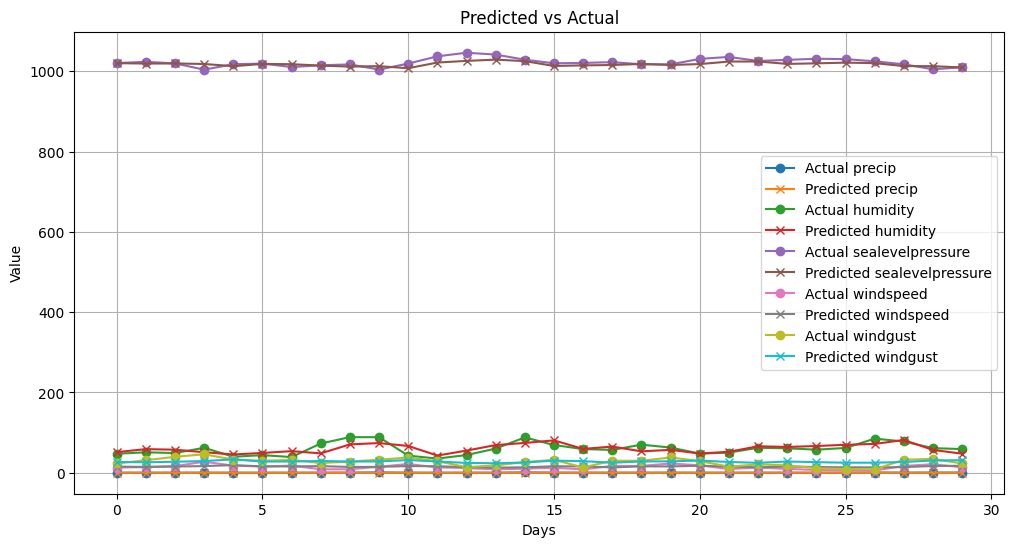

In [ ]:
def plot_predictions(y_true, y_pred, targets, n_days=30):
    plt.figure(figsize=(12, 6))
    for i, col in enumerate(targets):
        plt.plot(y_true[-n_days:, i], label=f'Actual {col}', marker='o')
        plt.plot(y_pred[-n_days:, i], label=f'Predicted {col}', marker='x')
    plt.title("Predicted vs Actual")
    plt.xlabel("Days")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example:
plot_predictions(y_test, y_pred, targets)


In [ ]:
from sklearn.metrics import brier_score_loss

# Convert predicted precip to "rain yes/no" (threshold 0.5mm)
y_true_rain = (y_test[:, targets.index('precip')] > 0.5).astype(int)
y_pred_rain_prob = y_pred[:, targets.index('precip')] / max(y_pred[:, targets.index('precip')].max(), 0.5)
brier = brier_score_loss(y_true_rain, y_pred_rain_prob)
print(f"Brier score for rain prediction: {brier:.3f}")


Brier score for rain prediction: 0.104
